### IMPORTANDO Y CARGANDO LAS LIBRERIAS

---





In [79]:
%cd C:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python\Facebook Prophet

c:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python\Facebook Prophet


In [80]:
#IMPORTAMOS LAS LIBRERIAS
import itertools
import prophet
import pandas as pd
import numpy as np

In [81]:
#OBTENEMOS LOS DATOS
data = pd.read_csv("Daily Bike Sharing.csv")
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [82]:
#incluimos dteday en las columnas 
dataset = data.loc[:, ["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head()

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


### TRANSFORMACIÓN DE LOS DATOS

In [83]:
# Date variable
dataset.dteday

0      2011-01-01
1      2011-01-02
2      2011-01-03
3      2011-01-04
4      2011-01-05
          ...    
726    2012-12-27
727    2012-12-28
728    2012-12-29
729    2012-12-30
730    2012-12-31
Name: dteday, Length: 731, dtype: object

es un objeto, y puede ser un problema

In [84]:
dataset.dteday = pd.to_datetime(dataset.dteday,
                                format = "%Y-%m-%d")

In [85]:
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [86]:
#RENOMBRAMOS LA VARIABLE QUE QUEREMOS PRONOSTICAR
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


### Holidays

In [87]:
holidays_dates = dataset[dataset.holiday == 1].ds
holidays_dates = pd.DataFrame({'holiday': 'holi',
                               'ds': pd.to_datetime(holidays_dates),
                               'lower_windows': -3,
                               'upper_windows': 1})
holidays_dates.head()

,holiday,ds,lower_windows,upper_windows
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [88]:
# removing holiday column
dataset = dataset.drop(columns="holiday")
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


### CONJUNTO DE ENTRENAMIENTO Y PRUEBAS

In [89]:
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
700,2012-12-01,5191,0,2,0.298333,0.316904,0.806667,0.059704


### Facebook Prophet

In [90]:
#Facebook prophet model
m = Prophet(growth='linear', 
            yearly_seasonality= True, 
            weekly_seasonality= True, 
            daily_seasonality=False, 
            holidays= holidays_dates, 
            seasonality_mode="multiplicative", 
            seasonality_prior_scale=10, 
            holidays_prior_scale=10, 
            changepoint_prior_scale=0.05)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

18:30:20 - cmdstanpy - INFO - Chain [1] start processing
18:30:21 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting

In [91]:
# Create Future Dataframe
future = m.make_future_dataframe(periods=len(test_set), 
                                 freq="D")
future.head(1)

,ds
0,2011-01-01


In [92]:
# Merge Regressors
future = pd.concat([future, dataset.iloc[:,2:]], 
                   axis=1)
future.head()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1,1,0.226957,0.229270,0.436957,0.186900


In [93]:
# Forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,1785.394032,69.553605,1878.452991,1785.394032,1785.394032,-0.039357,-0.039357,-0.039357,-0.301170,...,0.000000,0.000000,0.000000,-0.286958,-0.286958,-0.286958,0.0,0.0,0.0,965.595232
1,2011-01-02,1794.578226,-104.338123,1712.931549,1794.578226,1794.578226,-0.042670,-0.042670,-0.042670,-0.306846,...,0.000000,0.000000,0.000000,-0.279246,-0.279246,-0.279246,0.0,0.0,0.0,791.384961
2,2011-01-03,1803.762421,125.205186,1983.029735,1803.762421,1803.762421,-0.097735,-0.097735,-0.097735,-0.093444,...,0.133669,0.133669,0.133669,-0.270041,-0.270041,-0.270041,0.0,0.0,0.0,1051.175674
3,2011-01-04,1812.946615,208.267364,2067.725382,1812.946615,1812.946615,-0.090123,-0.090123,-0.090123,-0.085614,...,0.133669,0.133669,0.133669,-0.259475,-0.259475,-0.259475,0.0,0.0,0.0,1121.664552
4,2011-01-05,1822.130810,427.715693,2214.974673,1822.130810,1822.130810,-0.084377,-0.084377,-0.084377,-0.012690,...,0.133669,0.133669,0.133669,-0.247705,-0.247705,-0.247705,0.0,0.0,0.0,1289.921225


In [94]:
# Predictions
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet[:5]

C:\Users\leoma\AppData\Local\Temp\ipykernel_15504\1699719305.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  predictions_prophet[:5]


700    4135.780668
701    3509.797791
702    5711.656038
703    5645.213089
704    5423.339601
Name: prophet, dtype: float64

### Visualization

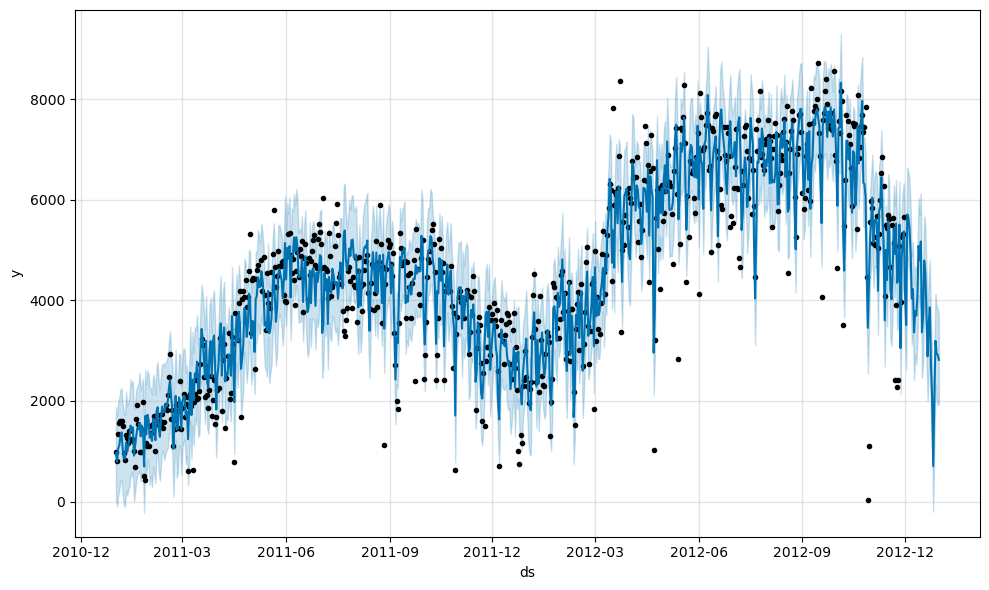

In [95]:
# visualization forecast
m.plot(forecast);

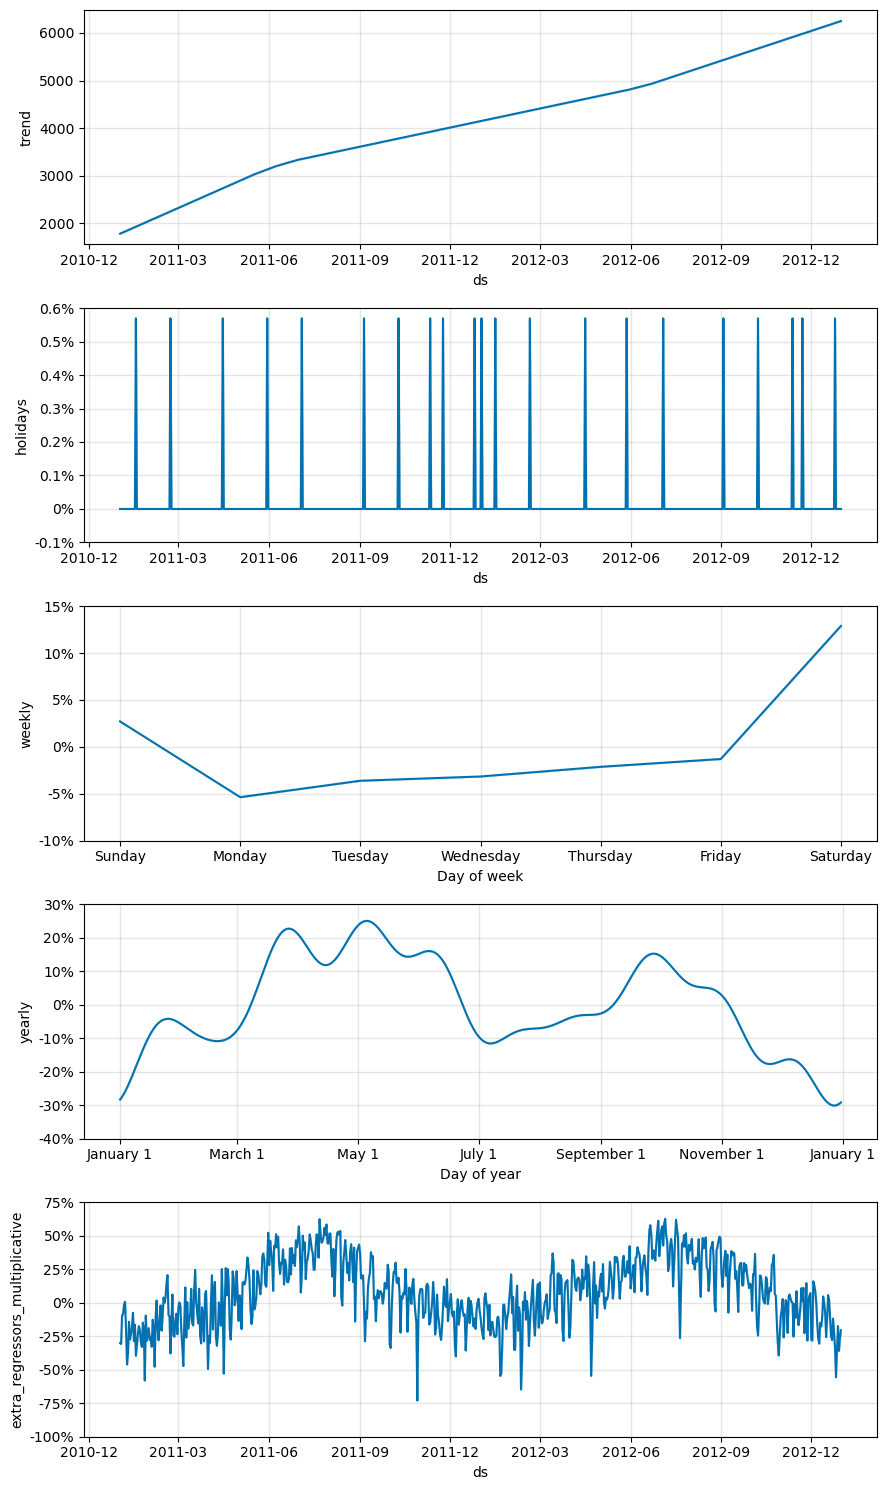

In [96]:
#plot components
m.plot_components(forecast);

### Model Assessment

In [97]:
# MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(round (mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))

857.0
1028.0


In [98]:
# MAPE function
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

35.26843827042457

### Cross-Validation

In [101]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                         horizon='31 days', # cuantos días en el futuro pronosticamos?
                         initial= '540 days', # a que dist. comenzamos la valid.cruzada? tiene sentido que siempre al menos dejemos un período completo
                         parallel= "processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8131.061532,7333.654608,8911.910593,5463,2012-06-28
1,2012-06-30,7163.437018,6440.683304,7937.282540,5687,2012-06-28
2,2012-07-01,7428.190456,6724.924712,8195.522699,5531,2012-06-28
3,2012-07-02,7217.463349,6427.329002,7957.998513,6227,2012-06-28
4,2012-07-03,7409.012244,6639.803521,8194.550935,6660,2012-06-28


In [102]:
# MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(round (mean_absolute_error(df_cv['y'], df_cv['yhat']),0))
print(round(np.sqrt(mean_squared_error(df_cv['y'],df_cv['yhat'])), 0))
print(MAPE(df_cv['y'], df_cv['yhat']))

1012.0
1265.0
126.45832623945583


Comparemos cada uno de los KPI versus lo que obtuvimos anteriormente, comenzando por la media absoluta
es decir que para este mes de diciembre parecía que al modelo le iba bien, pero el mes anterior en realidad no le iba tan bien.

Pero la sorpresa aquí es el MAPE que explotó absolutamente al 126%, lo que significa que hay algunas observaciones
que para nuestro error absoluto medio y nuestro error cuadrático medio, tienen muy poco valor.
Pero cuando se trata de nuestro MAPE, en realidad están adquiriendo mucho peso y, por lo tanto, está explotando.

### Hyperparameter Tuning

In [105]:
#Parameter grid
from sklearn.model_selection import ParameterGrid
Param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1],
              'holidays_prior_scale': [5, 10, 20],}
grid = ParameterGrid(Param_grid)
list(grid)[:3]

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [ ]:
# Hyper parameter tuning
rmse = []
for params in grid:
    #Build the model
    m = Prophet(growth='linear', 
            yearly_seasonality= True, 
            weekly_seasonality= True, 
            daily_seasonality=False, 
            holidays= holidays_dates, 
            seasonality_mode="multiplicative", 
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'], 
            changepoint_prior_scale=params['changepoint_prior_scale'])
    m.add_regressor('workingday')
    m.add_regressor('weathersit')
    m.add_regressor('temp')
    m.add_regressor('atemp')
    m.add_regressor('hum')
    m.add_regressor('windspeed')
    m.fit(training_set)

    #Cross-Validation (siempre para que no sea casualidad de que obtengamos un bueno o malo resultado)
        
    df_cv = cross_validation(m,
                         horizon='31 days', # cuantos días en el futuro pronosticamos?
                         initial= '540 days', # a que dist. comenzamos la valid.cruzada? tiene sentido que siempre al menos dejemos un período completo
                         parallel= "processes")
    
    #Gather the results
    error = np.sqrt(mean_squared_error(df_cv['y'],
                                       df_cv['yhat']))
    rmse.append(error)

In [109]:
# best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 5, 'holidays_prior_scale': 10, 'changepoint_prior_scale': 0.01}


### Final Prophet Model

In [119]:
#Build the model
m = Prophet(growth='linear', 
            yearly_seasonality= True, 
            weekly_seasonality= True, 
            daily_seasonality=False, 
            holidays= holidays_dates, 
            seasonality_mode="multiplicative", 
            seasonality_prior_scale=best_params['seasonality_prior_scale'],
            holidays_prior_scale=best_params['holidays_prior_scale'], 
            changepoint_prior_scale=best_params['changepoint_prior_scale'])
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

06:09:30 - cmdstanpy - INFO - Chain [1] start processing
06:09:30 - cmdstanpy - INFO - Chain [1] done processing


In [120]:
# Create Future Daraframe
future = m.make_future_dataframe(periods=len(test_set), 
                                 freq="D")
future = pd.concat([future, dataset.iloc[:,2:]], 
                   axis=1)
future.tail(1)

,ds,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,1,2,0.215833,0.223487,0.5775,0.154846


In [121]:
# Forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2407.878622,206.819557,2116.505729,2407.878622,2407.878622,-0.055594,-0.055594,-0.055594,-0.278762,...,0.000000,0.000000,0.000000,-0.273710,-0.273710,-0.273710,0.0,0.0,0.0,1205.100309
1,2011-01-02,2413.606475,91.060448,1948.971681,2413.606475,2413.606475,-0.060274,-0.060274,-0.060274,-0.287853,...,0.000000,0.000000,0.000000,-0.267571,-0.267571,-0.267571,0.0,0.0,0.0,969.364473
2,2011-01-03,2419.334328,364.514850,2238.538027,2419.334328,2419.334328,-0.138056,-0.138056,-0.138056,-0.188507,...,0.029315,0.029315,0.029315,-0.260048,-0.260048,-0.260048,0.0,0.0,0.0,1277.339755
3,2011-01-04,2425.062181,431.228323,2292.680358,2425.062181,2425.062181,-0.127303,-0.127303,-0.127303,-0.178112,...,0.029315,0.029315,0.029315,-0.251262,-0.251262,-0.251262,0.0,0.0,0.0,1365.832358
4,2011-01-05,2430.790034,641.330139,2523.955449,2430.790034,2430.790034,-0.119187,-0.119187,-0.119187,-0.111616,...,0.029315,0.029315,0.029315,-0.241355,-0.241355,-0.241355,0.0,0.0,0.0,1568.124574


In [122]:
# Extract predictions
predictions_prophet_tuned = forecast.yhat[-test_days:].rename("prophet_tuned")
#le damos un indice
predictions_prophet_tuned.index = test_set['ds']
predictions_prophet_tuned.head()

ds
2012-12-01    4100.171314
2012-12-02    3493.567193
2012-12-03    5627.019024
2012-12-04    5556.247572
2012-12-05    5336.772905
Name: prophet_tuned, dtype: float64

### Export forecasts

In [125]:
%cd C:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python

C:\Users\leoma\Desktop\projects\Modelos-de-Pronosticos-Series-Temporales-Python


In [126]:
predictions_prophet_tuned.to_csv('predictions_prophet_tuned.csv', index = True)